In [67]:
import base64
import json
import io
import cv2
import numpy as np
import requests
import uuid
import time
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from skimage import filters

In [68]:
def preview_strips(strips):
    fig, axs = plt.subplots(1, len(strips), figsize=(20, 4))
    for i, strip_base64 in enumerate(strips):
        img = Image.open(io.BytesIO(base64.b64decode(strip_base64)))
        if len(strips) > 1:
            axs[i].imshow(img)
            axs[i].axis("off")
            axs[i].set_title(f"Strip {i+1}")
        else:
            axs.imshow(img)
            axs.axis("off")
            axs.set_title(f"Strip {i+1}")
    plt.tight_layout()
    plt.show()

In [144]:
def texture_split(image_binary, preview=False):
    # Open the image
    img = Image.open(io.BytesIO(image_binary))
    img = img.resize((512, 512))

    # Convert image to numpy array
    img_array = np.array(img)

    # Calculate the average color for each column
    avg_colors = np.mean(img_array, axis=0)

    # Calculate the color difference between adjacent columns
    color_diff = np.sum(np.abs(np.diff(avg_colors, axis=0)), axis=1)

    # Apply Sobel edge detection
    edge_h = filters.sobel_h(img_array.mean(axis=2))
    edge_v = filters.sobel_v(img_array.mean(axis=2))
    edge_mag = np.sqrt(edge_h**2 + edge_v**2)
    edge_strength = np.mean(edge_mag, axis=0)

    # Combine color difference and edge strength
    combined_signal = color_diff * edge_strength[1:]

    # Find peaks in the combined signal
    peaks, _ = find_peaks(
        combined_signal, height=np.max(combined_signal) * 0.1, distance=20
    )

    # Add the start and end of the image to the peaks
    boundaries = np.concatenate(([0], peaks, [img_array.shape[1]]))

    # Ensure minimum width between boundaries, including the last strip
    filtered_boundaries = [boundaries[0]]
    for b in boundaries[1:]:
        if b - filtered_boundaries[-1] >= 8:
            filtered_boundaries.append(b)

    # Check if the last boundary meets the minimum width requirement
    if img_array.shape[1] - filtered_boundaries[-1] >= 8:
        filtered_boundaries.append(img_array.shape[1])

    # Split the image based on the detected boundaries
    strips = []
    for i in range(len(filtered_boundaries) - 1):
        left = filtered_boundaries[i]
        right = filtered_boundaries[i + 1]

        # Crop the image
        strip = img.crop((left, 0, right, img.height))
        strip = strip.resize((64, 64))

        # Crop the center 16x16 chunk
        strip = strip.crop((16, 16, 32, 32))

        # Convert to base64 and store in array
        buffered = io.BytesIO()
        strip.save(buffered, format="PNG")
        strips.append(base64.b64encode(buffered.getvalue()).decode())

    if preview:
        preview_strips(strips)
    return strips

In [125]:
def apply_texture(dress, textures, preview=False):
    image_binary = Image.open(io.BytesIO(dress))
    image_binary = image_binary.resize((512, 512))
    buffered = io.BytesIO()
    image_binary.save(buffered, format="PNG")
    base64_image = base64.b64encode(buffered.getvalue()).decode()
    applied_dresses = []
    for texture in textures:
        req = {
            "workflow": "texture",
            "inputs": [],
            "images": [
                {"node": "dress", "data": base64_image},
                {"node": "cloth", "data": texture},
            ],
        }
        result = requests.post("http://localhost:5000/workflow", json=req).json()
        if "images" in result:
            for image in result["images"]:
                applied_dresses.append(image)

    if preview:
        preview_strips(applied_dresses)
    return applied_dresses

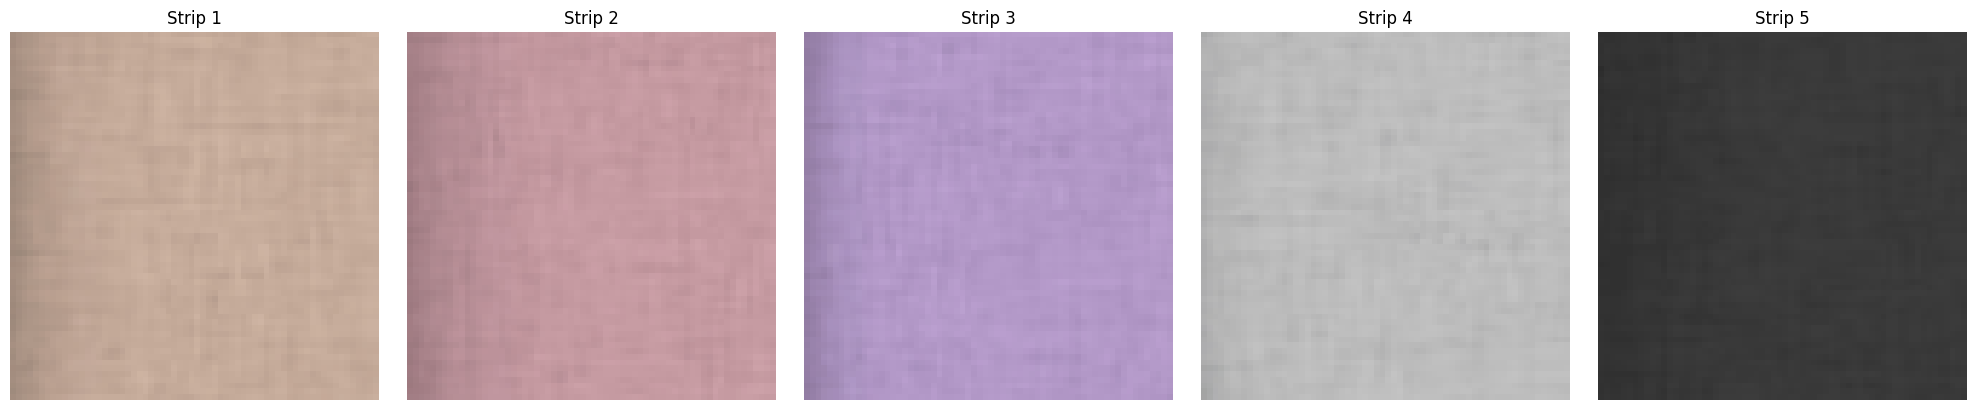

In [112]:
# Load the image of the texture of upper garment
image = cv2.imread("./resource/texture_shirt.png")
upper_garment = texture_split(image_binary=cv2.imencode(".png", image)[1], preview=True)

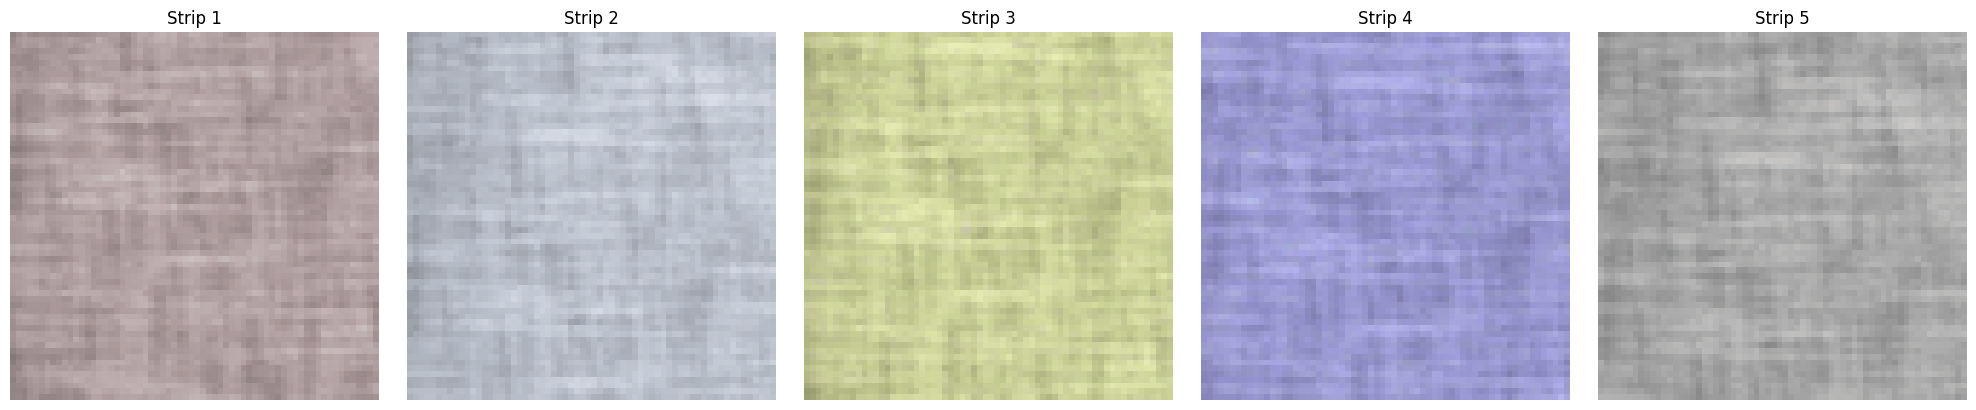

In [85]:
# Load the image of the texture of upper garment
image = cv2.imread("./resource/texture_pant.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
lower_garment = texture_split(image_binary=cv2.imencode(".png", image)[1], preview=True)

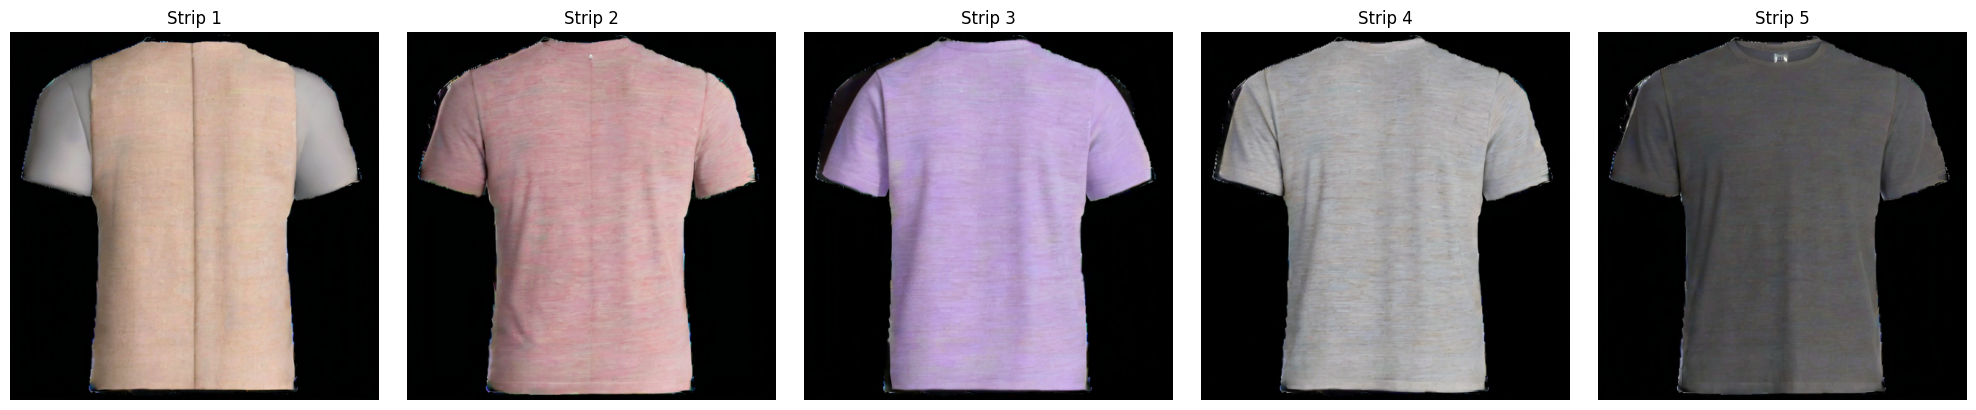

In [130]:
# Load the image of model shirt
image = cv2.imread("./resource/shirt.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
applied_upper_garment = apply_texture(
    dress=cv2.imencode(".png", image)[1], textures=upper_garment, preview=True
)

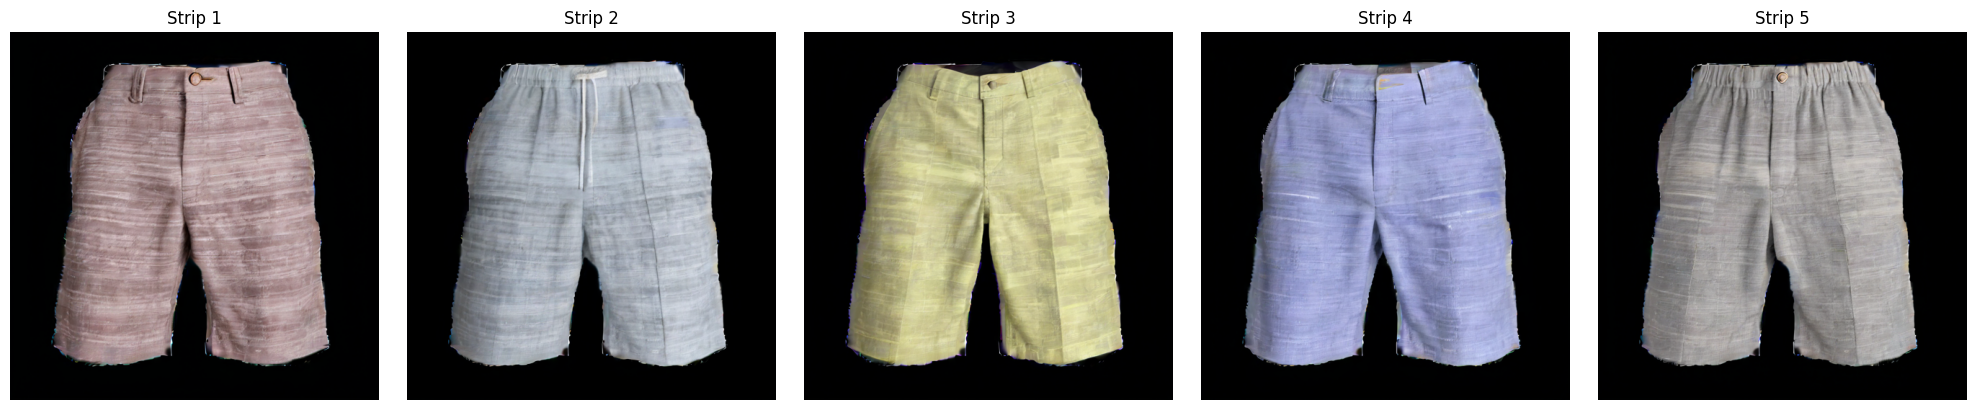

In [143]:
# Load the image of model pant
image = cv2.imread("./resource/pant.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
applied_upper_garment = apply_texture(
    dress=cv2.imencode(".png", image)[1], textures=lower_garment, preview=True
)

In [126]:
def wear_cloth(model, upper, lower, preview=False):
    req = {
        "workflow": "try_on_full",
        "inputs": [
            {"node": "upper_seg", "values": {"prompt": "shirt", "threshold": "0.4"}},
            {"node": "lower_seg", "values": {"prompt": "pants", "threshold": "0.4"}},
        ],
        "images": [
            {"node": "upper", "data": upper},
            {"node": "lower", "data": lower},
            {"node": "model", "data": model},
        ],
    }
    prompt_id = requests.post("http://localhost:5000/workflow", json=req).json()[
        "prompt_id"
    ]
    model_wear = []
    while True:
        print("Waiting for the result...")
        result = requests.get(
            "http://localhost:5000/history?prompt_id=" + prompt_id
        ).json()
        if "images" in result:
            for image in result["images"]:
                model_wear.append(image)
            break
        time.sleep(15)
    if preview:
        preview_strips(model_wear)
    return model_wear